# IPM DSS

## import modules

In [1]:
import pandas
#pandas.set_option('display.max_colwidth', 50)
import numpy as np
from weatherdata.ipm import WeatherDataHub
from openalea.dss import Hub


## Access to DSS catalog

In [2]:
h = Hub()
h.display()

,dss,models,pests,crops,description
0,no.nibio.vips,PSILARTEMP,[PSILRO],[DAUCS],The warning system model «Carrot rust fly temp...
1,no.nibio.vips,DELIARADIC,[HYLERA],[1BRSG],The model determines the flight period. It giv...
2,no.nibio.vips,MAMESTRABR,[BARABR],[1BRSG],The model for the warning system for cabbage m...
3,no.nibio.vips,PSILAROBSE,[PSILRO],[DAUCS],The warning system model is based on weekly ob...
4,no.nibio.vips,DELIARFOBS,"[HYLERA, HYLEFL]","[BRSOL, BRSOB, BRSOK]",The warning system model is based on weekly ob...
5,no.nibio.vips,NAERSTADMO,[PHYTIN],[SOLTU],The model is based on several years of experim...
6,no.nibio.vips,ALTERNARIA,[ALTESO],[SOLTU],TOMCAST is based on a model that was originall...
7,no.nibio.vips,NEGPROGMOD,[PHYTIN],[SOLTU],"From a specific date (50% germination), daily ..."
8,no.nibio.vips,SEPAPIICOL,[SEPTAP],[APUGD],This model is based on a calculation of how le...
9,no.nibio.vips,BREMIALACT,[BREMLA],[1LACG],TODO\n


## Get model and run model
To connect to the model, simply enter the dss name and model name

In [3]:
psilartemp=h.get(dss="no.nibio.vips",model="PSILARTEMP")

Once getted to model you can :
* display information of the model in order to identify input data required for the model and the output of the model
* run model according to information

### Display information of the model

In [4]:
psilartemp.informations(display="dataframe")

,name,id,description,type_of_decision,pests,crops,weather input,field_observation input,output,output_description
0,Carrot rust fly temperature model,PSILARTEMP,The warning system model «Carrot rust fly temp...,Short-term tactical,[PSILRO],[DAUCS],1002,None,"TMDD5C, THRESHOLD_1, THRESHOLD_2, THRESHOLD_3","Accumulated day degrees, Threshold for start o..."


**DSS model can be required weather data input or field observation inputs**
In this case model requiered weather information with 1002 parameter (see ipm weather description) to obtain weather you can request IPM weatherservices to  from weatherdata package (see weatherdata demo)

*Note:* weatherdata must be in json format according to IPM weather schema

In [5]:
# get weather data input for the model from the IPM plateform
ws=WeatherDataHub()
ws.list_resources
fmi=ws.get_ressource(name="Finnish Meteorological Institute measured data")

weather=fmi.data(stationId=[101533],parameters=[1002],interval=3600,display="json")

INFO:start connecting to station 101533


with weather data you can run model using run function to obtain model output in dataset format with variable metainformation

In [6]:
ds=psilartemp.run(weatherdata=weather)
ds

<xarray.Dataset>
Dimensions:      (time: 21)
Coordinates:
  * time         (time) datetime64[ns] 2020-06-12 2020-06-13 ... 2020-07-02
Data variables:
    TMDD5C       (time) float64 10.65 24.05 38.73 53.66 ... 268.7 277.5 286.2
    THRESHOLD_1  (time) float64 260.0 260.0 260.0 260.0 ... 260.0 260.0 260.0
    THRESHOLD_2  (time) float64 360.0 360.0 360.0 360.0 ... 360.0 360.0 360.0
    THRESHOLD_3  (time) float64 560.0 560.0 560.0 560.0 ... 560.0 560.0 560.0
Attributes:
    name:             Carrot rust fly temperature model
    id:               PSILARTEMP
    version:          1.0
    authors:          {'name': 'Berit Nordskog', 'email': 'berit.nordskog@nib...
    description:      The warning system model «Carrot rust fly temperature» ...
    description_url:  https://www.vips-landbruk.no/forecasts/models/PSILARTEMP/

### Plot data model
Once you have model output, you can plot result using plot function

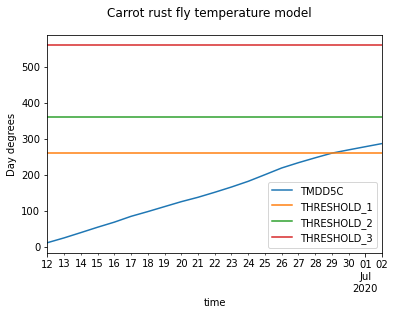

In [7]:
psilartemp.plot(ds)

### example with field observation

In [13]:
psilarobs=h.get(dss="no.nibio.vips",model="PSILAROBSE")
psilarobs.informations(display="")

{'name': 'Carrot rust fly observation model',
 'id': 'PSILAROBSE',
 'version': '1.0',
 'type_of_decision': 'Short-term tactical',
 'type_of_output': 'Risk indication',
 'description_URL': 'https://www.vips-landbruk.no/forecasts/models/PSILAROBSE/',
 'citation': None,
 'keywords': 'none',
 'platform_validated': False,
 'pests': ['PSILRO'],
 'crops': ['DAUCS'],
 'authors': [{'name': 'Tor J. Johansen',
   'email': 'tor.johansen@nibio.no',
   'organization': 'NIBIO'}],
 'execution': {'type': 'ONTHEFLY',
  'endpoint': 'https://coremanager.vips.nibio.no/models/PSILAROBSE/run/ipmd',
  'form_method': 'post',
  'content_type': 'application/json',
  'input_schema': '{\n  "type":"object",\n  "properties": {\n    "modelId": {"type": "string", "pattern":"^PSILAROBSE$", "title": "Model Id", "default":"PSILAROBSE", "description":"Must be PSILAROBSE"},\n    "configParameters": {\n      "title":"Configuration parameters",\n      "type": "object",\n      "properties": {\n        "timeZone": {"type": "st

In [11]:
# field observation data

data=df_reader_fieldObservation(longitude=11.025635,
                                latitude=59.715791,
                                timeZone="Europe/paris",sep=";",
                                dayfirst=True,
                                pestEPPOCode="PSILRO",
                                cropEPPOCode="DAUCS")
data
data.attrs

{'time': '2020-05-11T22:00Z',
 'location': {'type': 'Point', 'coordinates': ['11.025635', '59.715791']},
 'pestEPPOCode': 'PSILRO',
 'cropEPPOCode': 'DAUCS'}

In [10]:
ds=psilarobs.run(fieldObservation=data)
ds


<xarray.Dataset>
Dimensions:                 (time: 13)
Coordinates:
  * time                    (time) datetime64[ns] 2020-04-30 ... 2020-05-12
Data variables:
    TRAP_COUNT_THRESHOLD    (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    TRAP_COUNT_CROP_EDGE    (time) float64 nan nan nan nan ... nan nan 22.0 nan
    TRAP_COUNT_CROP_INSIDE  (time) float64 nan nan nan nan ... nan nan 2.0 nan
Attributes:
    name:             Carrot rust fly observation model
    id:               PSILAROBSE
    version:          1.0
    authors:          {'name': 'Tor J. Johansen', 'email': 'tor.johansen@nibi...
    description:      The warning system model is based on weekly observation...
    description_url:  https://www.vips-landbruk.no/forecasts/models/PSILAROBSE/

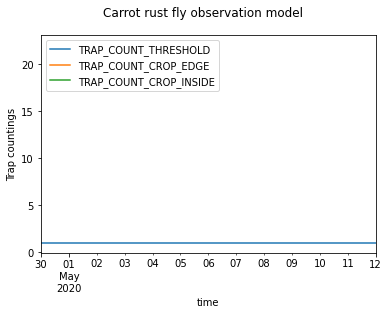

In [12]:
psilarobs.plot(ds)

## Other example of model

In [17]:
deliaradic=h.get(dss="no.nibio.vips",model="DELIARADIC") # get one model using dss and model
deliaradic.informations(display="dataframe") #display information about model

,name,id,description,type_of_decision,pests,crops,weather input,field_observation input,output,output_description
0,Cabbage fly flight period temperature model,DELIARADIC,The model determines the flight period. It giv...,Short-term tactical,[HYLERA],[1BRSG],"1002, 1112",None,"TMDD4C, TJM10DD4C, TMDD4CLT, TMDD4CUT, TJM10DD...","Accumulated air temperature day degrees, Accum..."


In [18]:
# from weatherdata.ipm import WeatherDataHub
ws= WeatherDataHub()
ws.list_resources

dmi=ws.get_ressource('DMI Pointweather service')

weather_dmi=dmi.data(timeStart="2022-01-30",
         timeEnd="2022-02-10",
         latitude=[56.488],
         longitude=[9.583],
         altitude=[0],
         parameters=[1002, 1112, 2001, 3002, 3101, 4002],
         interval=3600,
         timeZone="UTC",
         display="json")
weather_dmi



Del=h.get(dss="no.nibio.vips",model="DELIARADIC") 
ds=Del.run(weatherdata=weather_dmi,view='ds')
ds

<xarray.Dataset>
Dimensions:      (time: 11)
Coordinates:
  * time         (time) datetime64[ns] 2022-01-30 2022-01-31 ... 2022-02-09
Data variables:
    TMDD4C       (time) float64 0.0 0.0 0.0 0.0 1.56 ... 1.56 1.56 3.37 4.41
    TJM10DD4C    (time) float64 0.36 0.36 0.36 0.36 0.47 ... 1.34 1.34 1.55 1.83
    TMDD4CLT     (time) float64 185.0 185.0 185.0 185.0 ... 185.0 185.0 185.0
    TMDD4CUT     (time) float64 210.0 210.0 210.0 210.0 ... 210.0 210.0 210.0
    TJM10DD4CLT  (time) float64 140.0 140.0 140.0 140.0 ... 140.0 140.0 140.0
    TJM10DD4CUT  (time) float64 160.0 160.0 160.0 160.0 ... 160.0 160.0 160.0
Attributes:
    name:             Cabbage fly flight period temperature model
    id:               DELIARADIC
    version:          1.0
    authors:          {'name': 'Tor Johansen', 'email': 'tor.johansen@nibio.n...
    description:      The model determines the flight period. It gives inform...
    description_url:  https://www.vips-landbruk.no/forecasts/models/DELIARADIC/

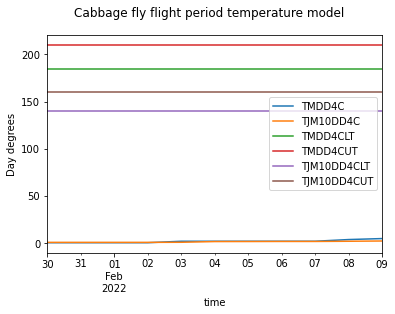

In [19]:
Del.plot(ds)

### PSILARTEMP Model

In [ ]:
h = Hub()
psi=h.get(dss="no.nibio.vips", model="PSILARTEMP")

psi.informations(display="dataframe")


In [ ]:
fmi=ws.get_ressource('Finnish Meteorological Institute measured data',df=None)

fmiweather=fmi.data(stationId=[101104],
                    parameters=[1002,3002],
                    display="json",
                    timeZone="Europe/Oslo",
                    varname="name")

In [ ]:
ds=psi.run(weatherdata=fmiweather,view='ds')
ds

In [ ]:
psi.plot(ds)


In [ ]:
data = pandas.read_csv(r"C:\Users\mlabadie\Documents\GitHub\echap\share\data\weather_data\Boigneville_2012_2013_h.csv", names=['date', 'h', 'temperature_air',
                                        'relative_humidity', 'rain',
                                        'wind_speed', 'global_radiation'],
                sep=';', decimal=',', skiprows=2, encoding='latin-1')

data.index = pandas.to_datetime(data['date'].map(str) + ' ' + data['h'],
                            dayfirst=True)
data['global_radiation'] *= (10000. / 3600)
# convert wind km/h -> m.s-1
data['wind_speed'] *= (1000. / 3600)
data=data.drop(columns=["date","h","relative_humidity","rain","wind_speed","global_radiation"])
data

weather=ws.get_ressource(name=None, df=data)
weather=weather.dataframe_to_ipm(longitude=3.87,
                         latitude=43.61,
                         altitude=0,
                         timezone="Europe/Paris",
                         interval=3600,
                         convert_name={'temperature_air': 1002,"relative_humidity": 3001,"rain": 2001,"wind_speed": 4005,"global_radiation": 5001 },
                         display="json")
# import json
ds=psi.run(weatherdata=weather,view="ds")
psi.plot(ds)

In [ ]:
h=Hub()
psiobs=h.get(dss="no.nibio.vips",model="PSILAROBSE")
psiobs.informations(display="dataframe")

#  dataset with observation
fieldObservation=pandas.DataFrame(index= pandas.date_range(start="2020-05-01",end="2020-05-10",tz="UTC",freq="H"),columns=["trapCountCropEdge","trapCountCropInside"])
fieldObservation.loc["2020-05-05T12:00:00Z", "trapCountCropEdge"] = 22
fieldObservation.loc["2020-05-05T12:00:00Z", "trapCountCropInside"] = 2

#attributs of observation
fieldObservation.attrs={"location":{"type":"Points","coordinates":["11.025635","59.715791"]},
          "time":'2020-05-05T12:00:00Z',
          "pestEPPOCode":"SEPTA",
          "cropEPPOCode":"APUGD"}

ds=psiobs.run(fieldObservation=fieldObservation,view="ds")
psiobs.plot(ds)


### NAERSTADMO model

In [ ]:
h=Hub()
ws=WeatherDataHub()
land=ws.get_ressource(name="Landbruksmeteorologisk tjeneste")
weather_land=land.data(stationId=[46],parameters=[2001, 5001, 1002, 3002, 3101],display="json")

NAERSTADMO=h.get(model="NAERSTADMO")

ds=NAERSTADMO.run(weatherdata=weather_land)
ds
NAERSTADMO.plot(ds)
